# Detecção de Retas e Círculos com a Transformada de Hough

A **Transformada de Hough** detecta formas geométricas (retas, circunferências etc.) a partir de pontos de borda. O OpenCV já traz implementações prontas: HoughLines / HoughLinesP (retas) e HoughCircles (círculos). A ideia central é que cada pixel de borda “vota” nas formas que poderiam passar por ele. Ao final, os parâmetros com mais votos correspondem às formas mais prováveis.

In [ ]:
import cv2
import util.auxiliar as aux
from util import hough_helper # helper com funções para visualização
from matplotlib import pyplot as plt
import numpy as np

# Detecção de retas usando a Transformada de Hough

Como mencionado, para detectar retas usando a Transformada de Hough, verificamos cada ponto de borda e geramos todas as retas possíveis que poderiam passar por ele (em termos de parâmetros $\rho$ e $\theta$). Cada combinação $(\rho,\theta)$ recebe um “voto”. As retas com mais votos representam alinhamentos reais na imagem.

## Encontrar os pontos de borda
O primeiro passo é usar Canny (precisa de imagem em tons de cinza). Depois alimentamos o resultado em Hough.

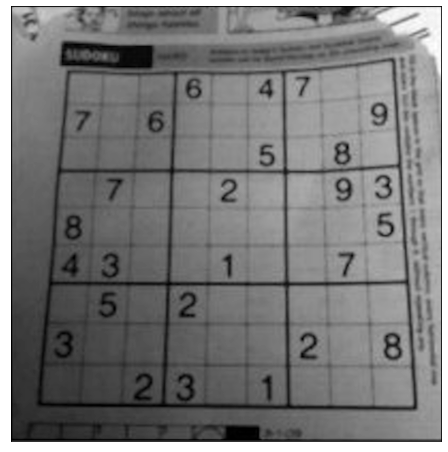

In [3]:
img = cv2.imread('img/dave.jpg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img)

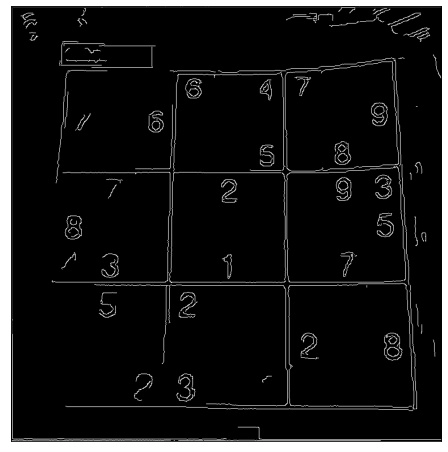

In [4]:
bordas = hough_helper.auto_canny(img)
plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(bordas)

## Uso da função HoughLines


O uso básico da função para a detecção de retas com a Transformada de Hough é:

    lines = cv2.HoughLines( image, rho, theta, threshold )
    

- `image`: Imagem de 8 bits contendo os pontos de borda na cor branca
- `lines`: Matriz de saída das linhas detectadas. Cada linha da matriz contém 2 elementos (ρ,θ):
    + `ρ` é a distancia da reta à origem das coordenadas (0,0)
    + `θ` é o ângulo da reta
- `rho`: Resolução da distância em pixels. 1 pixel está OK.
- `theta`: Resolução do ângulo em radiandos. 1 rad está OK.
- `threshold`: Limiar de detecção da reta. São retornadas apenas aquelas retas com número suficiente de votos (>`threshold`).

A partir da imagem acima, vamos detectar as retas usando a Transformada de Hough e depois desenhá-las na imagem original.

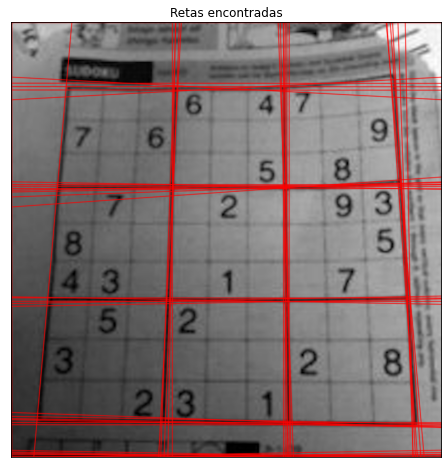

In [5]:
lines = cv2.HoughLines(bordas, 1, np.pi/180, 100)
img_retas = hough_helper.desenha_retas(img.copy(), lines)

plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img_retas, "Retas encontradas")


Aplicamos *Non-Maximum Suppression*: se uma reta forte (muitos votos) foi escolhida, descartamos outras muito próximas em $(ρ, θ)$. Isto reduz duplicatas quase coincidentes.

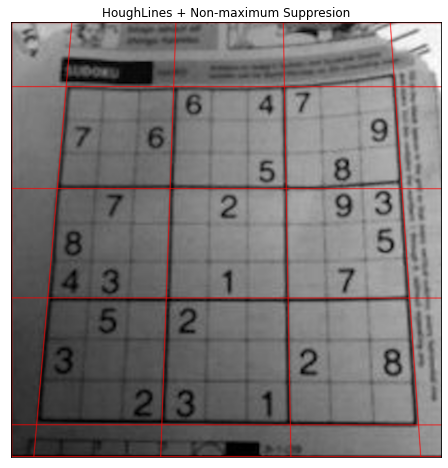

In [6]:
lines = cv2.HoughLines(bordas, 1, np.pi/180, 100)
suppressed_lines = hough_helper.non_max_suppression(lines, 40, np.radians(20))
img_retas_ = hough_helper.desenha_retas(img.copy(), suppressed_lines)

plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img_retas_, "HoughLines + Non-maximum Suppresion")

E se quisermos apenas retas horizontais?

Como `HoughLines` retorna $(ρ, θ)$ (θ é o ângulo da normal), retas horizontais têm normal quase vertical: θ perto de π/2 (≈1.57 rad). Então filtramos um intervalo estreito em torno disso.

**Pergunta:** Como seria para retas verticais? Teste na célula abaixo.

[[[1.0, 1.5707964]], [[1.0, 0.0]], [[487.0, 1.5707964]], [[767.0, 1.5707964]], [[294.0, 1.5707964]], [[711.0, 1.5707964]], [[-480.0, 3.1241393]], [[114.0, 1.5707964]], [[-667.0, 3.0717795]], [[291.0, 0.034906585]], [[107.0, 0.08726646]]]
[[[1.0, 1.5707964]], [[487.0, 1.5707964]], [[767.0, 1.5707964]], [[294.0, 1.5707964]], [[711.0, 1.5707964]], [[114.0, 1.5707964]]]


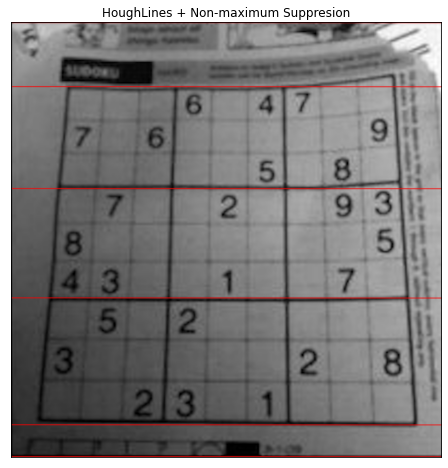

In [7]:
print(suppressed_lines)

horizontal_lines = []
for line in suppressed_lines:
    rho, theta = line[0]
        
    if 1.4 < theta < 1.6: 
        horizontal_lines.append([[rho, theta]])

print(horizontal_lines)
img_retas_ = hough_helper.desenha_retas(img.copy(), horizontal_lines)

plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img_retas_, "HoughLines + Non-maximum Suppresion")


## A Função HoughLinesP

Versão probabilística (mais eficiente) da Hough clássica. Em vez de $(ρ, θ)$ retorna diretamente segmentos: (x1,y1,x2,y2), ou seja, em vez de retornar os parâmetros da treta, retorna uma lista de segmentos de reta identificados pelos pontos `inicial` e `final`.

Está função é útil para cenas com muitas bordas e retas fragmentadas. [Docs](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)



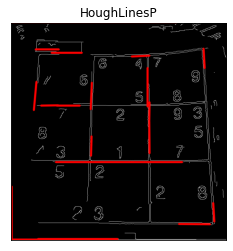

In [8]:
lines = cv2.HoughLinesP(bordas, 10, np.pi/180.0, threshold=60, minLineLength=60, maxLineGap=10)

a,b,c = lines.shape

hough_img_rgb = cv2.cvtColor(bordas, cv2.COLOR_GRAY2BGR)

for i in range(a):
    # Faz uma linha ligando o ponto inicial ao ponto final, com a cor vermelha (BGR)
    cv2.line(hough_img_rgb, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 5, cv2.LINE_AA)
    
hough_helper.mostra_imagem(hough_img_rgb, "HoughLinesP")

## Encontrando circunferências na imagem

A implementação da transformada de Hough para encontrar circunferências funciona de forma que cada borda curva “aponta” possíveis centros; onde muitos apontam, há um círculo. No OpenCV, a função HoughCircles emprega algumas otimizações que tornam desnecessário encontrar as bordas da imagem antes.

No entanto, se usarmos a imagem resultante da magnitude do gradiente, teremos um melhor resultado, pois as bordas estarão mais detacadas.

Pré‑processamento útil:

- Leve redução do contraste para equilibrar a iluminação na imagem (Equalização, `cv2.equalizeHist` ou ajuste de iluminação com `cv2.createCLAHE`)
- Uso do filtro da mediana para atenuação de ruído (Filtro de Mediana)

O uso básico da função para a detecção de circunferências com a Transformada de Hough é:

```python
circles = cv2.HoughCircles(image, method, dp, minDist, param1, param2, minRadius, maxRadius)

```

- `image`: Imagem de 8 bits onde as circunferências serão procuradas
- `method`: método usado para encontrar os possíveis centros de cada circunferência. Aqui vamos usar `cv2.HOUGH_GRADIENT`.
- `dp`: resolução usada na procura pelos centros das circunferências
- `minDist`: menor distância permitida entre os centros das circunferências encontradas
- `param1`: limiar empregado na detecção dos pontos de borda
- `param2`: limiar de detecção da circunferência
- `minRadius`: menor raio da circunferência a ser encontradas
- `maxRadius`: maior raio da circunferência a ser encontradas

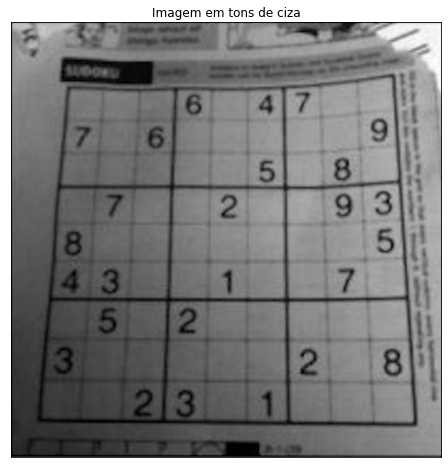

In [ ]:
plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img, "Imagem em tons de cinza")

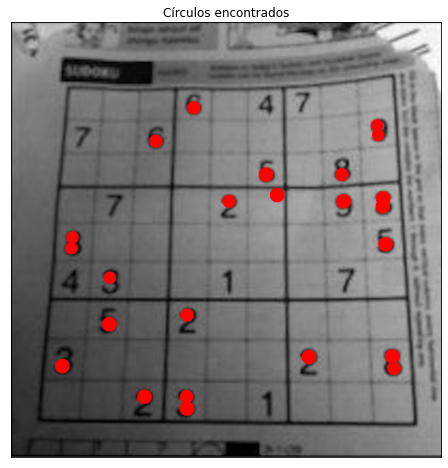

In [10]:
circles = cv2.HoughCircles(img, method=cv2.HOUGH_GRADIENT, dp=1, minDist=12, param1=40, param2=13, minRadius=10, maxRadius=14)

img_circles = hough_helper.desenha_circulos(img, circles)
plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img_circles, "Círculos encontrados")

## Prática 5.2: Vanishing Point

Neste exercício você deve detectar os pontos de fuga (vanishing points) na imagem da estrada abaixo.

![](img/frame01.jpg)

Em fotografia, o ponto de fuga é o ponto no qual linhas paralelas parecem convergir na distância devido à perspectiva. Na imagem acima, as linhas da estrada e as linhas das árvores parecem convergir em um ponto no horizonte.

Crie um arquivo chamado `vanishing_point.py` com uma função chamada `find_vanishing_point`. Está função deve receber uma imagem como entrada e retornar as coordenadas do ponto de fuga, assuma apenas **um** ponto de fuga na imagem.

Calcule a interseção em uma função separada chamada `line_intersection`, que deve receber dois segmentos de reta (x1,y1,x2,y2) e retornar o ponto de interseção (x,y).

**Dica:** Utilize filtro de cor para isolar as linhas brancas da pista, depois aplique Canny para encontrar bordas mais relevantes.

**Dica:** Utilize a HoughLinesP para detectar as linhas na imagem, escolha uma linha com inclinação positiva e outra com inclinação negativa. Depois calcule a interseção dessas linhas para encontrar o ponto de fuga.

Seu script deve conter a seguinte função `main` para testar a função `find_vanishing_point`:

## Dica: Cálculo da interseção de duas retas

Para calcular a interseção de duas retas dadas por dois pontos cada, você pode usar a seguinte fórmula:

![Interseção de Retas](img/retas.png)

Seja o ponto $A:(a_x, a_y)$ e o ponto $B:(b_x, b_y)$

Queremos encontrar uma reta $r: y = mx + h$ que passa por $A$ e $B$, em que $m$ é o *coeficiente angular* e $h$ é o intercepto ou coeficiente linear da reta.

Temos que:

$m = \frac{\Delta_y}{\Delta_x} = \frac{b_y - a_y}{b_x - a_x}$

Uma vez encontrado o valor de $m$, a substituição a seguir permite encontrar a equação da reta:

$m = \frac{y - a_y}{x - a_x}$

$mx - ma_x = y - a_y$

$mx = y - a_y + ma_x$

$y = mx -ma_x + a_y$

$h = a_y - ma_x$


$y = mx - ma_x + a_y$

### Interseção de Ruas Retas

Temos que na interseção as duas retas se encontram num ponto $(x_i, y_i)$

Sejam as retas $r1: y = m1x + h1$ e $r2: y = m2x + h2$

Vamos encontrar o ponto $x_i$ em que os valores de $y_i$ serão iguais:

$m1x_i + h1 = m2x_i + h2$

$(m1 - m2)x_i = h2 - h1$

$x_i = \frac{h2 - h1}{m1 - m2}$

$y_i = m1x_i + h1$

### Dados de teste:

Caso precise testar seu código, você pode conferir com estes valores. As retas definidas por pontos $r1: (P_1, P_2)$ e $r2: (Q_1, Q_2)$, para os valores:

```python

p1 = (3.0, 2.5)
p2 = (4.0, 0.6)
q1 = (1.0, 2.4)
q2 = (0.6, 1.1)
```

Encontram-se no ponto `(1.7572 4.8611)`